# Use VISION to plot only selected a region 

In [1]:
# IMPORT LIBRARIES
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.mlab as mlab
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,LatitudeLocator, LongitudeLocator)
import os
import cf
import numpy as np
import numpy.ma as ma
from datetime import datetime

#################################
# Colour scales, colour-blind-friendly for map or line plotting (from https://colorbrewer2.org/)
# Diverging colour scales (11 colours)
# blue to red; green to magenta
blue_to_red = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffff','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695']
green_to_magenta=['#276419','#4d9221','#7fbc41','#b8e186','#e6f5d0','#ffffff','#fde0ef','#f1b6da','#de77ae','#c51b7d','#8e0152']
# Sequential colour scales (10 colours)
# white to blue; white to purple; yellow to red/brown; pink to magenta; yellow to green
w2b=['#ffffff','#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#08519c','#08306b']
w2p=['#ffffff','#f7fcfd','#e0ecf4','#bfd3e6','#9ebcda','#8c96c6','#8c6bb1','#88419d','#810f7c','#4d004b']
y2r=['#ffffff','#ffffcc','#ffeda0','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#bd0026','#800026']
y2b=['#ffffff','#ffffe5','#fff7bc','#fee391','#fec44f','#fe9929','#ec7014','#cc4c02','#993404','#662506']
p2m=['#ffffff','#fff7f3','#fde0dd','#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177','#49006a']
y2g=['#ffffff','#ffffe5','#f7fcb9','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#006837','#004529']
#################################
# Values in colour bar
diff_lev=[-25,-20,-15,-10,-5,5,10,15,20,25]
log_lev=[0.001,0.01,0.03,0.1,0.3,1.00,3.0,10.,30.]
lin_lev=[1,2,3,4,5,6,7,8,9]
#################################

In [2]:
# SELECT OPTIONS HERE
outdir='/home/vagrant/Plots/'
select_species='O3'
# Select specific start/end year for the analysis (if required)
l_subset_time=True ; start_t='2015-01-01' ; end_t='2020-12-31'
# Select latitudes and altitudes for the analysis (if required).
l_subset_lats= True ; selected_lats= [30,60]     
l_subset_alts= True ; selected_alts=[5000,10000] # units = m

In [3]:
# READ AND PROCESS FAAM DATA

# Define variables for FAAM data
source1='FAAM'
sourcedir1='/home/vagrant/Tutorials/UMvn13.9/data/Task16/FAAM_ozone_cf_compliant_2010_2020/'
slabel1='FAAM O3 '
vunits1=' (ppbv)'
vfactor1=1.
vmin1=3. # removes negative values and very low values collected during taxiing
vscale1=y2r 
vlevs1=[x*10 for x in lin_lev]

# Read and concatenate data
rdata1=cf.read(sourcedir1+'*.nc')
rdata1=rdata1.concatenate()

# Create label (for plot title) and filename (for output)
plot_title1 = source1+' '+select_species+' '

outfile1=outdir+source1+'_'+select_species

# If subsetting dataset update plot_title and filename accordingly

# Select specific times
if l_subset_time:
    time_spec=str(start_t[0:4])+'_'+str(end_t[0:4])
    plot_title1=plot_title1+' ('+str(start_t[0:5])+str(end_t[0:4])+')'
    outfile1=outfile1+'_'+time_spec
    rdata1 = rdata1.subspace(time=cf.wi(cf.dt(start_t), cf.dt(end_t)))

# Select altitudes
if l_subset_alts:
    alt_spec=str(selected_alts[0]/1000.)+'-'+str(selected_alts[1]/1000.)+'km'
    plot_title1=plot_title1 + ' for '+ alt_spec
    outfile1=outfile1+'_'+alt_spec
    rdata1 = rdata1.subspace(altitude=cf.wi(selected_alts[0], selected_alts[1]))

# Select latitudes    
if l_subset_lats:
    lat_spec=str(selected_lats[0])+':'+str(selected_lats[1])
    plot_title1=plot_title1 + ' [lats='+ lat_spec+']'
    outfile1=outfile1+'_'+lat_spec
    rdata1 = rdata1.subspace(latitude=cf.wi(selected_lats[0], selected_lats[1]))

# Apply conversion factors
rdata1.data=rdata1.data * vfactor1
# Remove values below a set minimum
if vmin1 is not None:
    rdata1=rdata1.where(rdata1.array <= vmin1, cf.masked)

# Extract coordinates
lat = rdata1.coordinate('latitude').array
lon = rdata1.coordinate('longitude').array
# Extract data
obs = rdata1.array

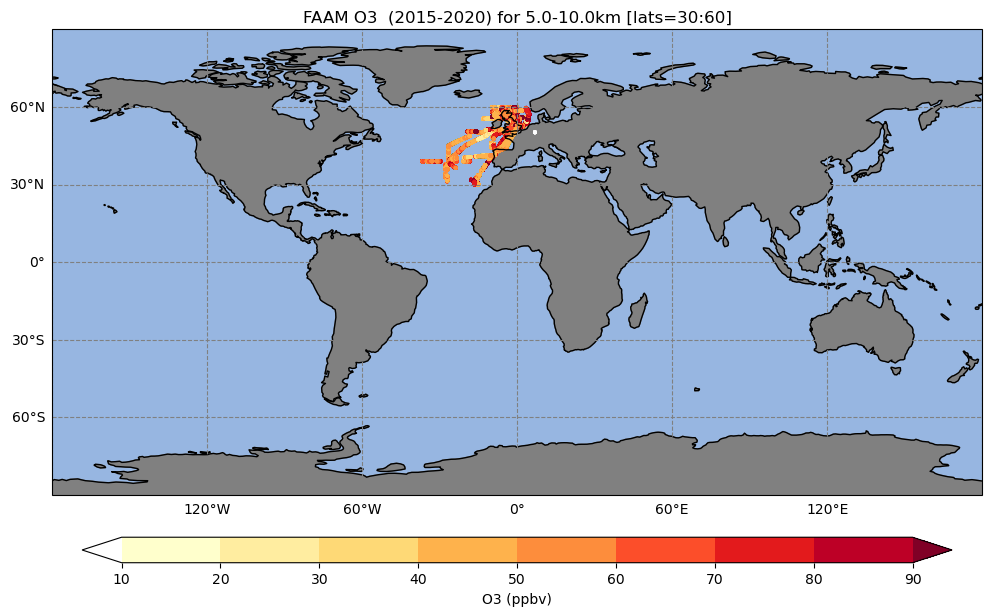

In [4]:
# PLOT MAP OF FAAM OZONE

# Define figure and size
fig = plt.figure(figsize=(12, 17))
# Define Axes (ax1) and choose cartopy projection for map 
# See here for more projections: https://earth-env-data-science.github.io/lectures/mapping_cartopy.html
ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
# Add cartopy features
ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.LAND, color='grey')    # optional: edgecolor='black'

# Add coastlines
ax1.coastlines(resolution='110m')  # coastline resolution options are '110m', '50m', '10m'
# Define region to plot as [lon1,lon2,lat1,lat2] (default=global plot)
ax1.set_extent([-179.9,179.9,-90,90], crs=ccrs.PlateCarree())
# Set title for the plot
ax1.set_title(plot_title1)
# Plot gridlines and grid labels (choose color and style of gridlines)
gl=ax1.gridlines(draw_labels=True,color='grey',linestyle='--')
gl.top_labels = False
gl.right_labels = False
 
# Set levels and choose color scale
mylev=vlevs1
clrmap = matplotlib.colors.ListedColormap(vscale1)
# get discrete colormap
norm = matplotlib.colors.BoundaryNorm(mylev, clrmap.N, extend='both')

# Add data
ax1.scatter(lon, lat, c=obs, norm=norm,cmap=clrmap, s=3 )
# Get position/size of plot and work out position/size of colorbar relative to plot
pos1 = ax1.get_position()
pos2 = [pos1.x0 + 0.025, pos1.y0 - 0.04,  pos1.width -0.025*2, 0.015]

#add colorbar as a separate axes
ax2 = fig.add_axes(pos2)
cb2 = matplotlib.colorbar.ColorbarBase(ax2, cmap=clrmap,norm=norm,orientation='horizontal')

cb2.set_label(select_species + vunits1)

plt.savefig(outfile1+'_map.png',dpi=300,bbox_inches='tight')


In [5]:
# READ AND PROCESS UKCA DATA (COLOCATED ON FAAM FLIGHT TRACKS USING VISION)

# Define variables for UKCA data
source2='UKESM'
sourcedir2='/home/vagrant/Tutorials/UMvn13.9/data/Task16/UKCA_ozone_cf_compliant_2010_2020/'
slabel2='UKESM O3 '
vunits2=' (ppbv)'
vmin2=None
vfactor2=1.e9/1.657 # converts UKCA data (kg/kg) to ppbv 
vscale2=y2r
vlevs2=[x*10 for x in lin_lev]

# Read and concatenate data
rdata2=cf.read(sourcedir2+'*.nc')
rdata2=rdata2.concatenate()

# Create label (for plot title) and filename (for output)
plot_title2 = source2+' '+select_species+' '

outfile2=outdir+source2+'_'+select_species

# If subsetting dataset update plot_title and filename accordingly

# Select specific times
if l_subset_time:
    time_spec=str(start_t[0:4])+'_'+str(end_t[0:4])
    plot_title2=plot_title2+' ('+str(start_t[0:5])+str(end_t[0:4])+')'
    outfile2=outfile2+'_'+time_spec
    rdata2 = rdata2.subspace(time=cf.wi(cf.dt(start_t), cf.dt(end_t)))

# Select altitudes
if l_subset_alts:
    alt_spec=str(selected_alts[0]/1000.)+'-'+str(selected_alts[1]/1000.)+'km'
    plot_title2=plot_title2 + ' for '+ alt_spec
    outfile2=outfile2+'_'+alt_spec
    rdata2 = rdata2.subspace(altitude=cf.wi(selected_alts[0], selected_alts[1]))

# Select latitudes    
if l_subset_lats:
    lat_spec=str(selected_lats[0])+':'+str(selected_lats[1])
    plot_title2=plot_title2 + ' [lats='+ lat_spec+']'
    outfile2=outfile2+'_'+lat_spec
    rdata2 = rdata2.subspace(latitude=cf.wi(selected_lats[0], selected_lats[1]))

# Apply conversion factors
rdata2.data=rdata2.data * vfactor2
# Remove values below a set minimum
if vmin2 is not None:
    rdata2=rdata2.where(rdata2.array <= vmin2, cf.masked)

# Extract coordinates
lat = rdata2.coordinate('latitude').array
lon = rdata2.coordinate('longitude').array
# Extract data
mod = rdata2.array

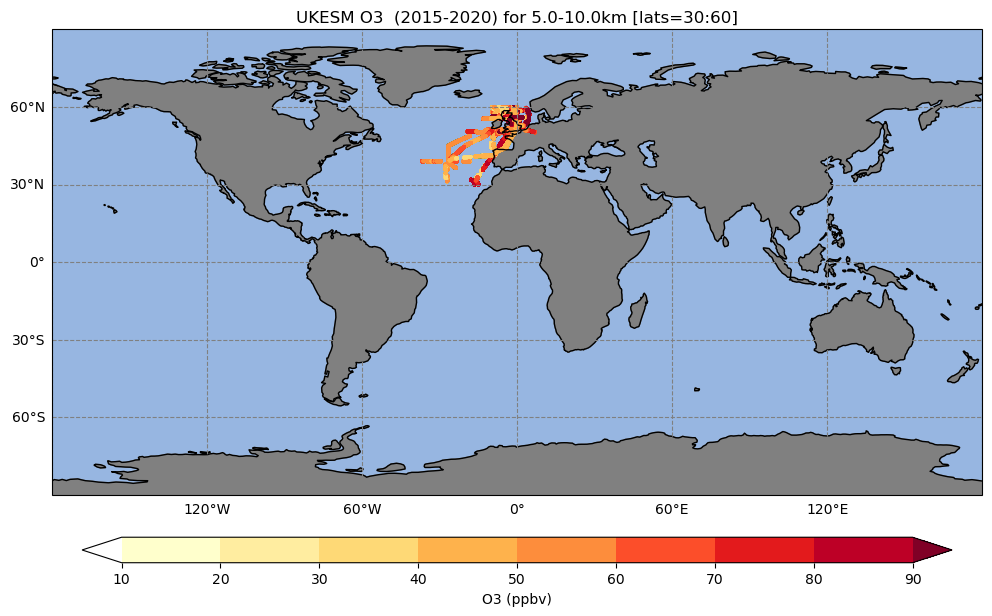

In [6]:
# PLOT MAP OF UKCA OZONE

# Define figure and size
fig = plt.figure(figsize=(12, 17))
# Define Axes (ax1) and choose cartopy projection for map 
# See here for more projections: https://earth-env-data-science.github.io/lectures/mapping_cartopy.html
ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
# Add cartopy features
ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.LAND, color='grey')    # optional: edgecolor='black'

# Add coastlines
ax1.coastlines(resolution='110m')  # coastline resolution options are '110m', '50m', '10m'
# Define region to plot as [lon1,lon2,lat1,lat2] (default=global plot)
ax1.set_extent([-179.9,179.9,-90,90], crs=ccrs.PlateCarree())
# Set title for the plot
ax1.set_title(plot_title2)
# Plot gridlines and grid labels (choose color and style of gridlines)
gl=ax1.gridlines(draw_labels=True,color='grey',linestyle='--')
gl.top_labels = False
gl.right_labels = False
 
# Set levels and choose color scale
mylev=vlevs2
clrmap = matplotlib.colors.ListedColormap(vscale2)
# get discrete colormap
norm = matplotlib.colors.BoundaryNorm(mylev, clrmap.N, extend='both')

# Add data
ax1.scatter(lon, lat, c=mod, norm=norm,cmap=clrmap, s=3 )
# Get position/size of plot and work out position/size of colorbar relative to plot
pos1 = ax1.get_position()
pos2 = [pos1.x0 + 0.025, pos1.y0 - 0.04,  pos1.width -0.025*2, 0.015]

#add colorbar as a separate axes
ax2 = fig.add_axes(pos2)
cb2 = matplotlib.colorbar.ColorbarBase(ax2, cmap=clrmap,norm=norm,orientation='horizontal')

cb2.set_label(select_species + vunits1)

plt.savefig(outfile2+'_map.png',dpi=300,bbox_inches='tight')


In [7]:
# PROCESS DIFFERENCE BETWEEN UKCA AND FAAM DATA

# Create label (for plot title) and filename (for output)
plot_title_diff = source2+' - '+source1+' '

outfile_diff=outdir+source2+'-'+source1+'_'+select_species

# If subsetting dataset update plot_title and filename accordingly

# Select specific times
if l_subset_time:
    time_spec=str(start_t[0:4])+'_'+str(end_t[0:4])
    plot_title_diff=plot_title_diff+' ('+str(start_t[0:5])+str(end_t[0:4])+')'
    outfile_diff=outfile_diff+'_'+time_spec

# Select altitudes
if l_subset_alts:
    alt_spec=str(selected_alts[0]/1000.)+'-'+str(selected_alts[1]/1000.)+'km'
    plot_title_diff=plot_title_diff + ' for '+ alt_spec
    outfile_diff=outfile_diff+'_'+alt_spec

# Select latitudes    
if l_subset_lats:
    lat_spec=str(selected_lats[0])+':'+str(selected_lats[1])
    plot_title_diff=plot_title_diff + ' [lats='+ lat_spec+']'
    outfile_diff=outfile_diff+'_'+lat_spec

# No need to extract coordinates (same as FAAM or UKCA)

# Calculate difference 
diff = mod - obs

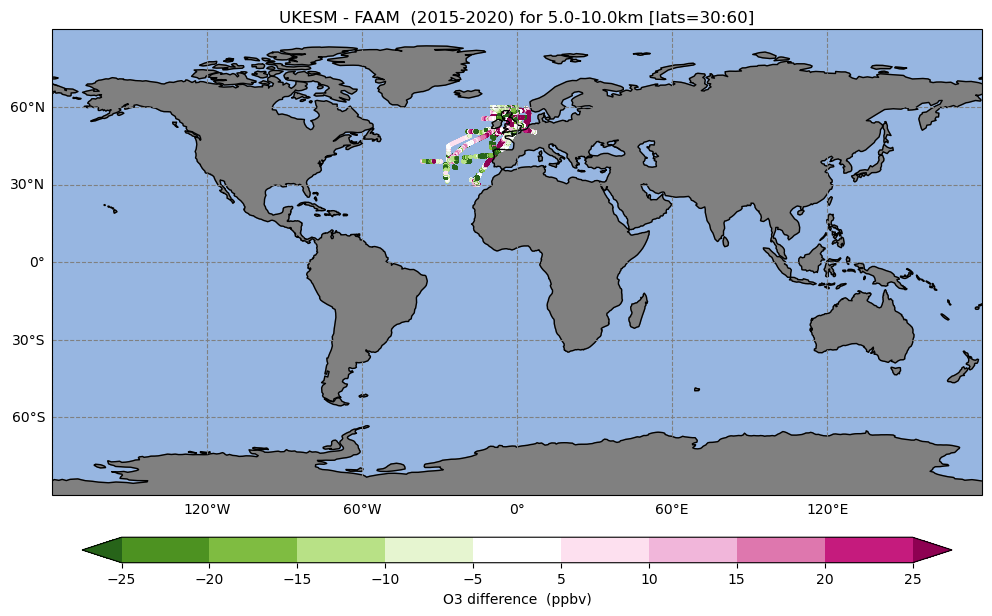

In [8]:
# PLOT DIFERENCE MAP: UKCA - FAAM 

# Select color scale and levels for colour bar
vlevs_diff=diff_lev
vscale_diff=green_to_magenta 

# Define figure and size
fig = plt.figure(figsize=(12, 17))
# Define Axes (ax1) and choose cartopy projection for map 
# See here for more projections: https://earth-env-data-science.github.io/lectures/mapping_cartopy.html
ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
# Add cartopy features
ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.LAND, color='grey')    # optional: edgecolor='black'

# Add coastlines
ax1.coastlines(resolution='110m')  # coastline resolution options are '110m', '50m', '10m'
# Define region to plot as [lon1,lon2,lat1,lat2] (default=global plot)
ax1.set_extent([-179.9,179.9,-90,90], crs=ccrs.PlateCarree())
# Set title for the plot
ax1.set_title(plot_title_diff)
# Plot gridlines and grid labels (choose color and style of gridlines)
gl=ax1.gridlines(draw_labels=True,color='grey',linestyle='--')
gl.top_labels = False
gl.right_labels = False
 
# Set levels and choose color scale
mylev=vlevs_diff
clrmap = matplotlib.colors.ListedColormap(vscale_diff)
# get discrete colormap
norm = matplotlib.colors.BoundaryNorm(mylev, clrmap.N, extend='both')

# Add data
ax1.scatter(lon, lat, c=diff, norm=norm,cmap=clrmap, s=3 )
# Get position/size of plot and work out position/size of colorbar relative to plot
pos1 = ax1.get_position()
pos2 = [pos1.x0 + 0.025, pos1.y0 - 0.04,  pos1.width -0.025*2, 0.015]

#add colorbar as a separate axes
ax2 = fig.add_axes(pos2)
cb2 = matplotlib.colorbar.ColorbarBase(ax2, cmap=clrmap,norm=norm,orientation='horizontal')

cb2.set_label(select_species +' difference ' + vunits1)

plt.savefig(outfile_diff+'_map.png',dpi=300,bbox_inches='tight')
